# Analysis of [Compass](https://github.com/YosefLab/Compass) results

In [1]:
# taken from https://github.com/YosefLab/Compass/blob/docs/notebooks/compass_analysis.py
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh', alpha = 0.1)[1], dtype='float64')
    return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

labeled_reactions = {}

relevant_subsystems = [
    'Fatty acid oxidation', 
    'Arachidonic acid metabolism',
    'Glycerophospholipid metabolism',
    'Sphingolipid metabolism',
    'Glycolysis/gluconeogenesis', 
    'Oxidative phosphorylation',
    'Pyrimidine synthesis',
    'Pyrimidine catabolism',
    'beta-Alanine metabolism'
]
eererere
# custom functions
def load_reactions(disease_reactions_file, control_reactions_file, disease_label, control_label):
    ddf = pd.read_csv(
        disease_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    cdf = pd.read_csv(
        control_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    for df, label in zip([ddf, cdf], [disease_label, control_label]):
        df.columns = ['_'.join([label, column]) for column in df.columns]
        
    df = ddf.merge(
        cdf,
        how = 'left',
        left_index = True,
        right_index = True
    )
    return df

In [36]:
# only need to be run if you didn't download it yet
#!wget https://github.com/YosefLab/Compass/raw/docs/notebooks/extdata/RECON2/reaction_metadata.csv -O ../compass/recon2_reaction_metadata.csv

In [2]:
reaction_metadata = pd.read_csv(
    "../compass/recon2_reaction_metadata.csv", 
    index_col = 0
)
reaction_metadata

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
...,...,...,...,...,...,...
MAL_Lte,Transport of L-malate,1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...,NaN,"Transport, extracellular",NaN,NaN
OROTGLUt,OROTGLUt,1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...,SLC22A7,"Transport, extracellular",NaN,NaN
PNTOte,Transport of (R)-Pantothenate,1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...,NaN,"Transport, extracellular",NaN,NaN


In [3]:
reaction_metadata[
    reaction_metadata.associated_genes.apply(lambda x: x.startswith('SLC7A5') if type(x) == str else False)
]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r1544,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-glutamine [c] + 1.00 * Glycine [e] --...,SLC7A5,"Transport, extracellular",NaN,0.0
r1546,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-methionine [c] -...,SLC7A5,"Transport, extracellular",NaN,0.0
r1547,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-tryptophan [c] -...,SLC7A5,"Transport, extracellular",NaN,0.0
r1548,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-phenylalanine [c...,SLC7A5,"Transport, extracellular",NaN,0.0
r1549,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * Glycine [e] + 1.00 * L-tyrosine [c] -->...,SLC7A5,"Transport, extracellular",NaN,0.0
...,...,...,...,...,...,...
r1658,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-valine [e] + 1.00 * L-homoserine [c] ...,SLC7A5,"Transport, extracellular",NaN,0.0
r1659,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-valine [e] + 1.00 * L-isoleucine [c] ...,SLC7A5,"Transport, extracellular",NaN,0.0
r1660,Amino Acid-Polyamine-Organocation (APC) TCDB:2...,1.00 * L-threonine [e] + 1.00 * L-homoserine [...,SLC7A5,"Transport, extracellular",NaN,0.0


In [4]:
np.sort(reaction_metadata.subsystem.unique())

array(['Alanine and aspartate metabolism', 'Alkaloid synthesis',
       'Aminosugar metabolism',
       'Androgen and estrogen synthesis and metabolism',
       'Arachidonic acid metabolism', 'Arginine and Proline Metabolism',
       'Bile acid synthesis', 'Biotin metabolism',
       'Blood group synthesis', 'Butanoate metabolism',
       'C5-branched dibasic acid metabolism', 'Cholesterol metabolism',
       'Chondroitin sulfate degradation', 'Chondroitin synthesis',
       'Citric acid cycle', 'CoA catabolism', 'CoA synthesis',
       'Cysteine Metabolism', 'Cytochrome metabolism',
       'D-alanine metabolism', 'Dietary fiber binding',
       'Eicosanoid metabolism', 'Exchange/demand reaction',
       'Fatty acid oxidation', 'Fatty acid synthesis',
       'Folate metabolism', 'Fructose and mannose metabolism',
       'Galactose metabolism', 'Glutamate metabolism',
       'Glutathione metabolism', 'Glycerophospholipid metabolism',
       'Glycine, serine, alanine and threonine metabo

In [5]:
reaction_metadata[
    reaction_metadata.subsystem.isin(relevant_subsystems)
]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
13DAMPPOX,"1,3-Diaminopropane:oxygen oxidoreductase (deam...",1.00 * trimethylenediaminium [c] + 1.00 * Wate...,AOC1; AOC2; AOC3,beta-Alanine metabolism,1.4.3.6,1.0
2DR1PP,2-deoxy-D-ribose 1-phosphate phosphorylase,1.00 * Water [c] + 1.00 * 2-Deoxy-D-ribose 1-p...,NaN,Pyrimidine catabolism,3.1.3.10,2.0
3DSPHR,3-Dehydrosphinganine reductase,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,KDSR,Sphingolipid metabolism,1.1.1.102,4.0
3HPCOAHYD,3-hydroxyisobutyryl-Coenzyme A hydrolase,1.00 * Water [c] + 1.00 * 3-hydroxypropanoyl-C...,HIBCH,beta-Alanine metabolism,3.1.2.4,4.0
A4GALTc,Lactosylceramide 4-alpha-galactosyltransferase,1.00 * galactosyl glucosyl ceramide [c] + 1.00...,A4GALT,Sphingolipid metabolism,2.4.1.228,4.0
...,...,...,...,...,...,...
TIGCRNe,transport of tiglyl carnitine into the extra c...,1.00 * tiglyl carnitine [c] --> 1.00 * tiglyl ...,NaN,Fatty acid oxidation,NaN,2.0
DTMPKm,dTMP kinase in mitochondria,1.00 * ATP [m] + 1.00 * dTMP [m] --> 1.00 * AD...,DTYMK,Pyrimidine synthesis,NaN,4.0
DUTPDP,dUTP diphosphatase,1.00 * Water [c] + 1.00 * dUTP [c] --> 1.00 * ...,NaN,Pyrimidine catabolism,NaN,3.0


## scRNA results

In [91]:
import itertools as it
def filter_reactions(
    rxn_penalties, 
    reaction_metadata,
    relevant_subsystems,
    label1, 
    label2, 
    filter_subsystems = True,
    filter_confidence = True
):
    for r in rxn_penalties.index:
        if r in reaction_metadata.index:
            rxn_penalties.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            rxn_penalties.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")
    rxn_penalties = rxn_penalties.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    if filter_subsystems and not filter_confidence:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.subsystem.isin(relevant_subsystems),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    elif filter_confidence and not filter_subsystems:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.confidence.isin([0, 4]),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    elif filter_confidence and filter_subsystems:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.confidence.isin([0, 4]) &
            rxn_penalties.subsystem.isin(relevant_subsystems),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
        
    else:
        rxn_penalties = rxn_penalties.loc[
            :,
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    return rxn_penalties

devstages = ['E14_5', 'P4', 'Adult']
celltypes = ['GABAergic', 'Mature_Glutamatergic']
reaction_penalties = {}
filter_subsystems = False
filter_confidence = True
for dev1, dev2 in it.combinations(devstages, 2):
    reaction_penalties[f'{dev1},{dev2}'] = {}
    for celltype in celltypes:
        filepaths = [
            f'../compass/timeseries_tpm/{dev1}_{celltype}',
            f'../compass/timeseries_tpm/{dev2}_{celltype}'
        ]
        rxn_penalties = load_reactions(
            *['/'.join([path, 'reactions.tsv.gz']) for path in filepaths],
            dev1, dev2
        )
        
        rxn_penalties = filter_reactions(
            rxn_penalties,
            reaction_metadata,
            relevant_subsystems,
            dev1,
            dev2,
            filter_confidence = filter_confidence,
            filter_subsystems = filter_subsystems
        )
            
        reaction_penalties[f'{dev1},{dev2}'][celltype] = rxn_penalties


dev1, dev2 = ['E14_5', 'P4']
filepaths = [
    f'../compass/timeseries_tpm/{dev1}_Immature_Glutamatergic',
    f'../compass/timeseries_tpm/{dev2}_Mature_Glutamatergic'
]
rxn_penalties = load_reactions(
    *['/'.join([path, 'reactions.tsv.gz']) for path in filepaths],
    dev1, dev2
)

rxn_penalties = filter_reactions(
    rxn_penalties,
    reaction_metadata,
    relevant_subsystems,
    dev1,
    dev2,
    filter_subsystems = filter_subsystems,
    filter_confidence = filter_confidence
)

reaction_penalties[f'{dev1},{dev2}']['Immature_to_Mature_Glutamatergic'] = rxn_penalties

In [93]:
# aggregate meta reactions
# see also https://yoseflab.github.io/Compass/notebooks/Demo.html#Metareactions
meta_penalties, meta_maps, meta_sources = {}, {}, {}
for key1, celldict in reaction_penalties.items():
    meta_penalties[key1], meta_maps[key1], meta_sources[key1] = {}, {}, {}
    for key2, rxn_penalties in celldict.items():
        rxn_penalties = rxn_penalties.copy() # copy to avoid modification of original
        rxn_penalties[rxn_penalties <= 1e-4] = 0
        rxn_penalties = rxn_penalties[
            np.all(rxn_penalties != 0, axis=1)
        ]
        rxn_penalties = rxn_penalties[
            rxn_penalties.max(axis=1) - rxn_penalties.min(axis=1) != 0
        ]
        meta_rxns_map = get_metareactions(rxn_penalties)
        meta_rxn_penalties = rxn_penalties.join(
            pd.DataFrame(
                meta_rxns_map, 
                columns=["meta_rxn_id"], 
                index = rxn_penalties.index
            )
        ).groupby("meta_rxn_id").mean()
        meta_penalties[key1][key2] = meta_rxn_penalties
        meta_maps[key1][key2] = meta_rxns_map
        meta_sources[key1][key2] = rxn_penalties

In [94]:
single_consistencies, meta_consistencies = {}, {}
for key1 in reaction_penalties.keys():
    single_consistencies[key1], meta_consistencies[key1] = {}, {}
    for key2 in reaction_penalties[key1].keys():
        single_consistencies[key1][key2] = get_reaction_consistencies(
            reaction_penalties[key1][key2]
        )
        meta_consistencies[key1][key2] = get_reaction_consistencies(
            meta_penalties[key1][key2]
        )

In [95]:
single_wilcox_test_results, meta_wilcox_test_results = {}, {}
for wilcoxon_test_results, rcs_dict, label in zip(
    [single_wilcox_test_results, meta_wilcox_test_results],
    [single_consistencies, meta_consistencies],
    ['single', 'meta']
):
    for key1, cell_dict in rcs_dict.items():
        dev1, dev2 = key1.split(',')
        wilcoxon_test_results[key1] = {}
        for celltype, rcs in cell_dict.items():
            dev1_clusters = rcs.columns[rcs.columns.str.startswith(dev1)]
            dev2_clusters = rcs.columns[rcs.columns.str.startswith(dev2)]
            wilcox_results = wilcoxon_test(
                rcs, 
                dev2_clusters, 
                dev1_clusters
            )
            if label == 'meta':
                wilcox_results_expanded = pd.DataFrame(
                    index = meta_sources[key1][celltype].index, 
                    columns = wilcox_results.columns
                )
                # wilcox_results_expanded contains index of single_rxn_penalties in same order
                for i in range(len(wilcox_results_expanded.index)):
                    # meta_rxns_map[i] returns metareaction index for the given enumerated reaction
                    if meta_maps[key1][celltype][i] in wilcox_results.index:
                        wilcox_results_expanded.loc[wilcox_results_expanded.index[i]] = \
                            wilcox_results.loc[meta_maps[key1][celltype][i]]

                wilcox_results = wilcox_results_expanded.dropna().astype('float64')
    
            wilcox_results['metadata_r_id'] = ""
            for r in wilcox_results.index:
                if r in reaction_metadata.index:
                    wilcox_results.loc[r, 'metadata_r_id'] = r
                elif r[:-4] in reaction_metadata.index:
                    wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
                else:
                    print("Should not occur")

            W = wilcox_results.merge(
                reaction_metadata, 
                how = 'left',
                left_on = 'metadata_r_id', 
                right_index = True, 
                validate = 'm:1'
            )
            wilcoxon_test_results[key1][celltype] = W

In [96]:
import plotly.express as px
import plotly
from IPython.display import HTML
def plotly_vulcano_plot(
    data, title, 
    pval_cutoff = 0.01, 
    pval_column = 'adjusted_pval', 
    color = None, 
    xlims = (-1.5, 1.5)
):
    fig = px.scatter(
        data, 
        x = 'cohens_d', 
        y = -np.log10(data[pval_column]), 
        hover_name = 'reaction_name',
        labels = {
            'y': '-log10(adjusted p-value)',
            'cohens_d': "Cohens's D",
        },
        color = color if color else None,
        hover_data = ['associated_genes', 'subsystem'],
        title = title,
        opacity = 0.5,
        range_x = xlims
    )
    if pval_cutoff:
        fig.add_hline(
            y = -np.log10(pval_cutoff), 
            line_width = 1, 
            line_dash = 'dash'
        )
    fig.add_vline(
        x = 0, 
        line_width = 1, 
        line_dash = 'dash'
    )
    fig.update_layout(
        width = 1000,
        height = 950
    )
    return fig

def plotly_category_plot(
    data, 
    title, 
    relevant_subsystems = None, 
    xlims = (-1.5, 1.5)
):
    if relevant_subsystems:
        data = data.loc[data.subsystem.isin(relevant_subsystems), :].copy()
        
    data['color'] = data.cohens_d.apply(
        lambda x: 'upregulated' if x >= 0 else 'downregulated'
    )
    data = data.sort_values(
        by = 'color',
    )
    fig = px.scatter(
        data,
        y = 'subsystem',
        x = 'cohens_d',
        hover_name = 'reaction_name',
        labels = {
            'cohens_d': "Cohens's D"
        },
        color = data.color,
        range_x = xlims
    )
    return fig

def save_html(fig, filename):
    fig.write_html(filename)
    plotly.offline.plot(
        fig, 
        filename = filename
    )

In [99]:
import itertools as it
comparisons = list(single_wilcox_test_results.keys())
key_tuples = list(
    it.product(comparisons, celltypes)
)
key_tuples.append(
    ('E14_5,P4', 'Immature_to_Mature_Glutamatergic')
)
key_tuples = sorted(
    key_tuples, 
    key = lambda x: x[0]
)
plot_titles = [
    ' '.join([*key_tuple, plot_type]) for key_tuple in key_tuples
    for plot_type in ['category', 'vulcano']  
]
for aggregation, data in zip(
    ['single', 'meta'],
    [single_wilcox_test_results, meta_wilcox_test_results]
):
    for i, (key1, key2) in enumerate(key_tuples):
        fig1 = plotly_category_plot(
            data[key1][key2],
            key2 + ' ' + ' vs. '.join(key1.split(',')[::-1]),
            xlims = None
        )
        fig2 = plotly_vulcano_plot(
            data[key1][key2],
            key2 + ' ' + ' vs. '.join(key1.split(',')[::-1]),
            pval_cutoff = 0.05,
            pval_column = 'adjusted_pval',
            xlims = None
        )

        key1 = key1.replace(',', '_')
        save_html(
            fig2,
            f'../plots/{key1}_{key2}.{aggregation}.compass.vulcano.html'
        )
        save_html(
            fig1,
            f'../plots/{key1}_{key2}.{aggregation}.compass.category.html'
        )

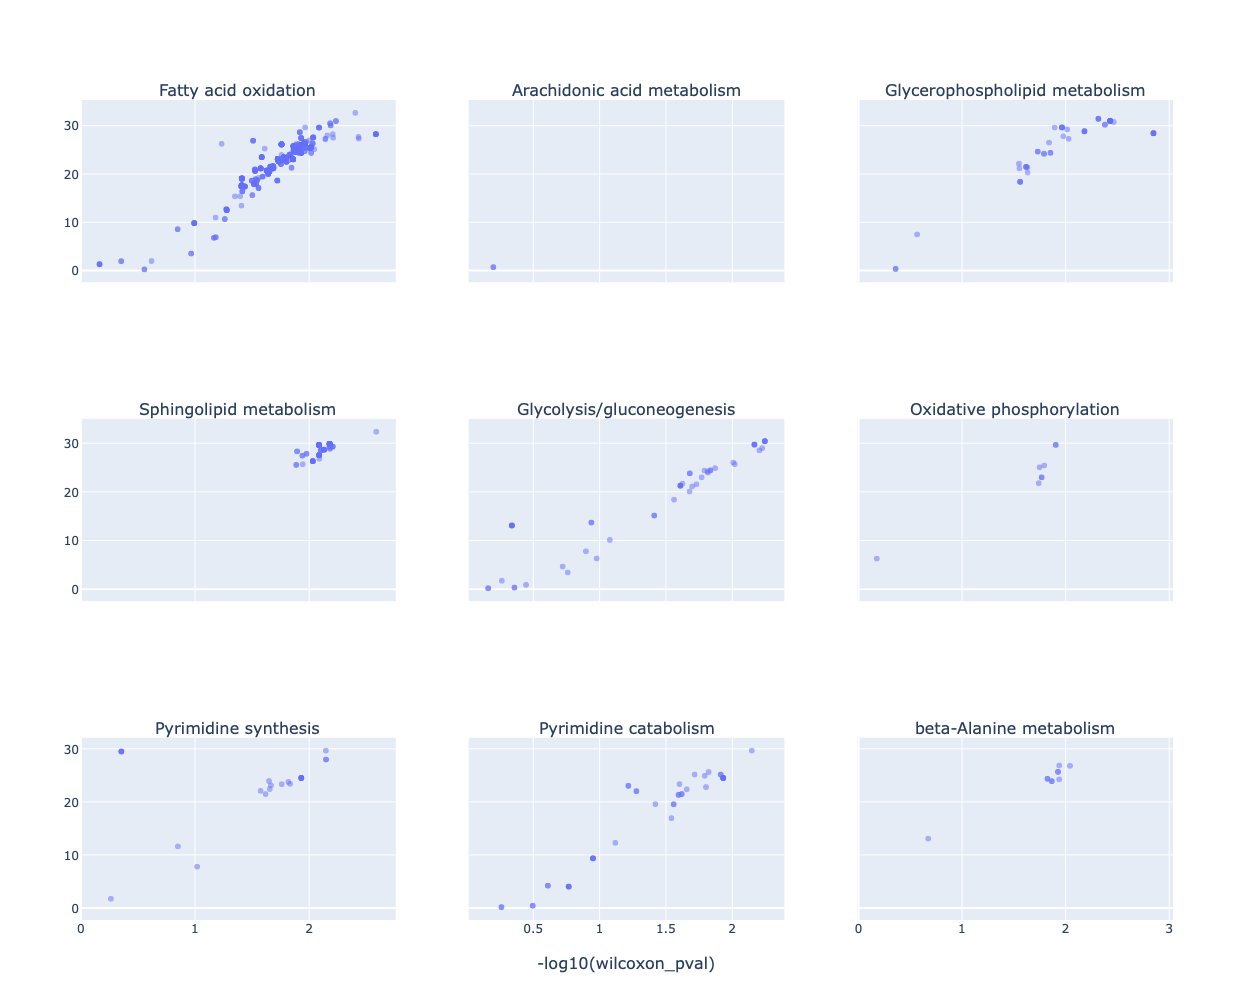

In [75]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows = 3, 
    cols = 3,
    subplot_titles = relevant_subsystems,
    shared_xaxes = True,
    shared_yaxes = True,
    x_title = '-log10(wilcoxon_pval)'
)
key1 = 'E14_5,P4'
key2 = 'Mature_Glutamatergic'
data = wilcoxon_test_results[key1][key2]
for i, j, subsystem in zip(
    [1, 1, 1, 2, 2, 2, 3, 3, 3], 
    [1, 2, 3, 1, 2, 3, 1, 2, 3], 
    relevant_subsystems):
    fig.add_trace(
        plotly_vulcano_plot(
            data[data.subsystem == subsystem],
            key2 + ' ' + ' vs. '.join(key1.split(',')[::-1]) + subsystem,
            pval_cutoff = 0.05,
            pval_column = 'wilcox_pval'
        ).data[0],
        row = i, 
        col = j
    )
    
fig.update_layout(
    width = 1000,
    height = 1000
)
fig.show()

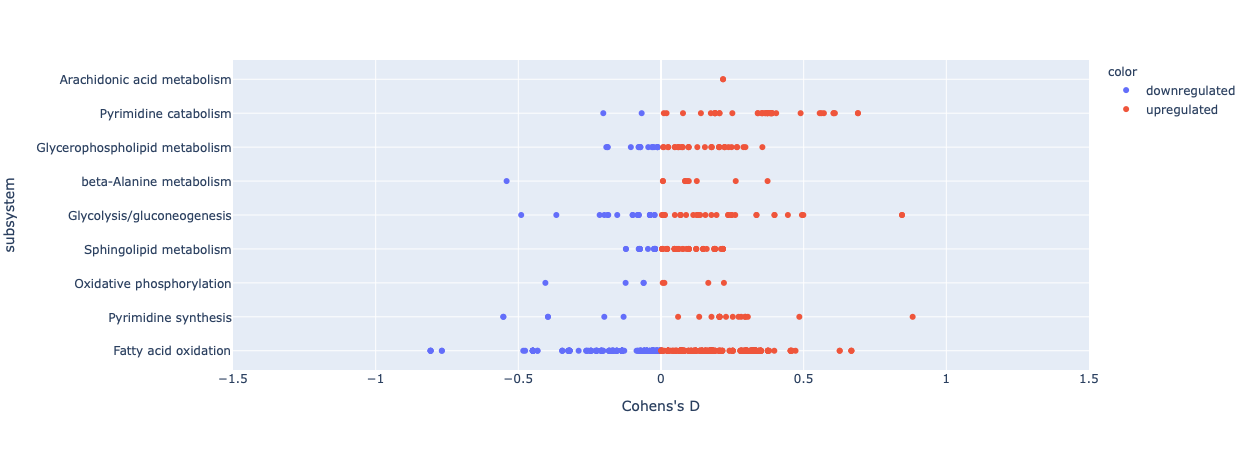

In [89]:
key = 'neurons'
plotly_category_plot(
    wilcoxon_test_results['meta'],
    key + ' ' + ' vs. '.join(labels[key]),
)

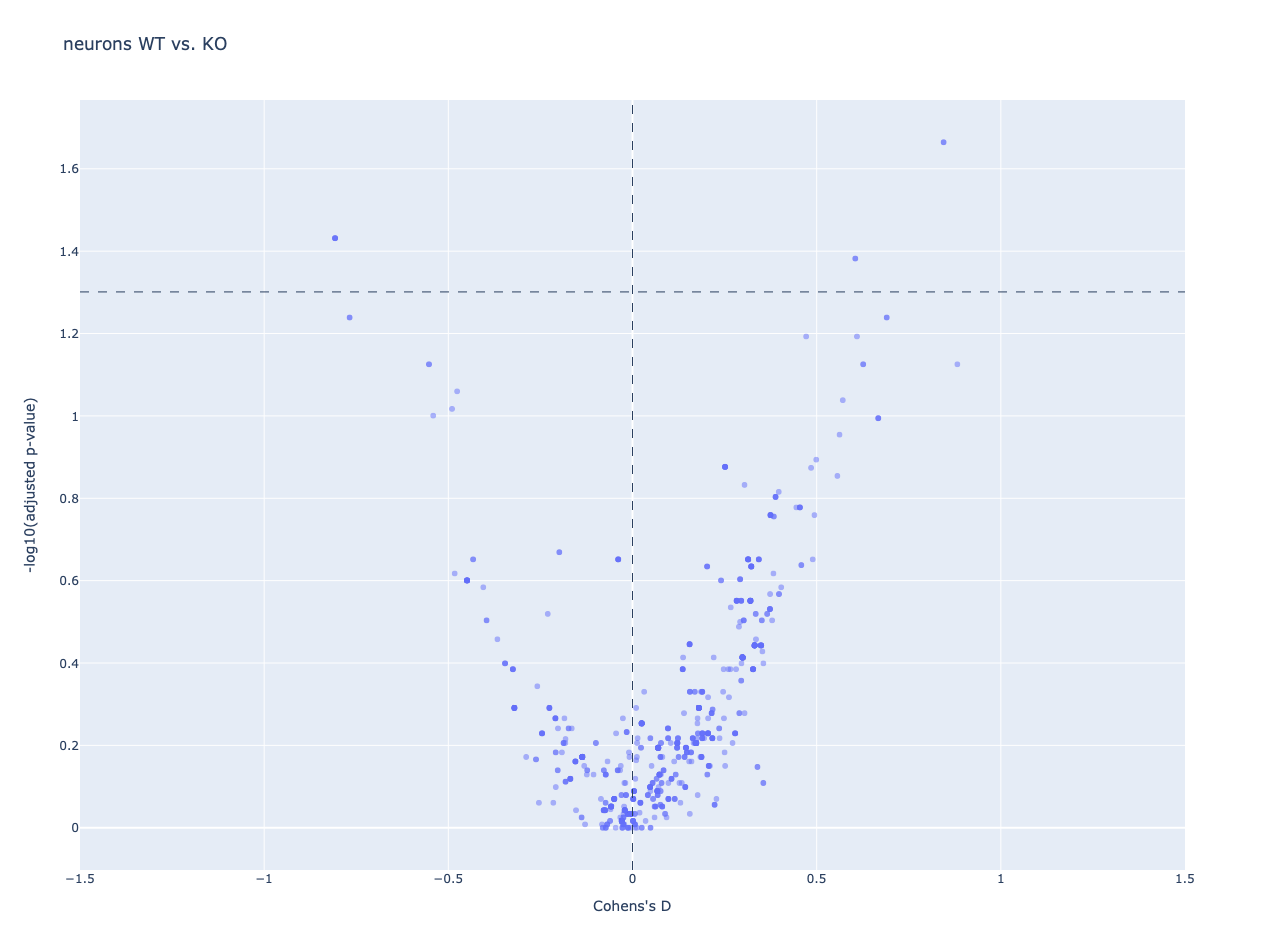

In [72]:
key = 'neurons'
plotly_vulcano_plot(
    wilcoxon_test_results['meta'],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = 0.05,
    pval_column = 'wilcox_pval'
)